## Transporte de um pulso inicial de poluição numa situação em que o vento seja constante
 Alejandro Delgado Peralta


In [62]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Exercicio com aproximação "forward" com Euler
Temos uma equação da adveção em 1D:

$$
\frac{\partial C}{\partial t} + U*\frac{\partial C}{\partial x} = 0,
$$

A condição inicial (CI) dada por uma gaussiana centrada em i=51, com decaimiento exponencial dado por `nr` (número de pontos) onde a amplitude da perturbação cai de um fator e:

$$
C(x,0) = C_{i,0} = C_0 \exp[\frac{-(i\Delta x - 51\Delta x)^2}{(nr*\Delta x)^2}]
$$

$$
U*\frac{\Delta t}{\Delta x} < 1
$$

Está bem o valor dt: 30.0 segundos


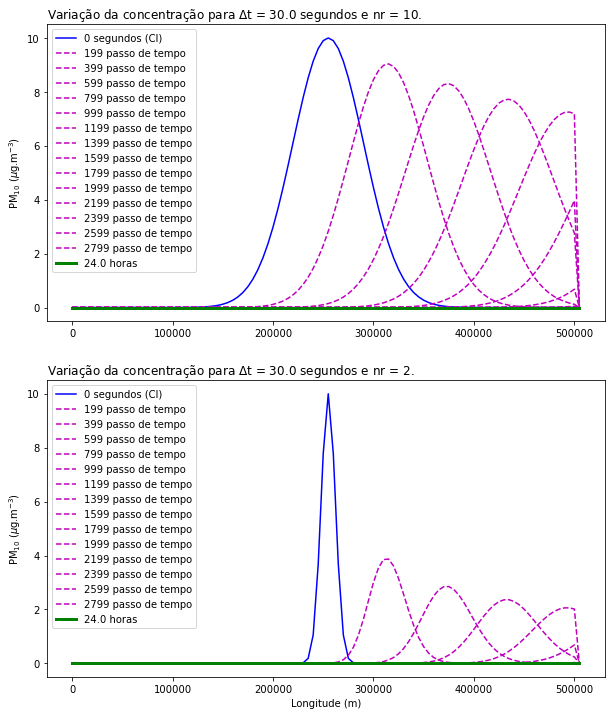

In [97]:
# Condições
# ------------------------------------------------------
Nx     = 101            # total points
dx     = 5000           # meters
Tempo  = 24*3600        # seconds
dt     = 6*dx/1000      # time lapse, WRF-Chem criteria CFL
Nt     = int(Tempo/dt)  # time steps, assuming by me
U_wind = 10             # m/s as wind speed
Co     = 10             # ug/m3 PM10

if U_wind*dt/dx <1:
    print(f"Está bem o valor dt: {dt} segundos")
else:
    print("Hey, melhor mudar por outro valor dt mais baixo")

# Condiçõa inicial
# ------------------------------------------------------
## Espaço
x = np.linspace(0,Nx*dx,Nx+1)

# Concentração 
def Conc(i,nr):
    """
    i:  index
    nr: número de pontos a partir do centro da gaussiana
    """
    Conc = Co*np.exp(-(i*dx-51*dx)**2/(nr*dx)**2)
    return Conc

## Valores de concentração para nr
C = np.zeros(Nx+1)    # para nr = 10
D = C.copy()          # para nr = 2 

for i in range(1,Nx+1):
    # Geramos a função Gaussiana
    C[i] = Conc(i, nr = 10)
    D[i] = Conc(i, nr = 2)

# Make a plot
fig, ax = plt.subplots(2,1, figsize=[10,12])

# Numeric solution using euler aproximation as first order
for n in range(1, Nt+1):
    if n == 1:
        ax[0].plot(x,C, label=f"{n-1} segundos (CI)", color='b')
        ax[1].plot(x,D, label=f"{n-1} segundos (CI)", color='b')

    if n % 200 == 0:
        ax[0].plot(x,C, label=f"{(n-1)} passo de tempo", color='m',linestyle='dashed')
        ax[1].plot(x,D, label=f"{(n-1)} passo de tempo", color='m',linestyle='dashed')

    cn = C.copy()
    dn = D.copy()
 
    for i in range(1,Nx):
        C[i] = cn[i] - U_wind*dt/dx*(cn[i]- cn[i-1])  # revisar y verlo a mano
        D[i] = dn[i] - U_wind*dt/dx*(dn[i]- dn[i-1])  # revisar y verlo a mano

ax[0].plot(x, C, label=f"{(n*dt)/3600} horas", color='g', lw=3)
ax[1].plot(x, D, label=f"{(n*dt)/3600} horas", color='g', lw=3)
ax[0].set_ylabel("PM$_{10}$ ($\mu$g.m$^{-3}$)")
ax[1].set_ylabel("PM$_{10}$ ($\mu$g.m$^{-3}$)")
ax[1].set_xlabel("Longitude (m)")
ax[0].set_title("Variação da concentração"+f" para $\Delta$t = {dt} segundos e nr = 10.", loc='left')
ax[1].set_title("Variação da concentração"+f" para $\Delta$t = {dt} segundos e nr = 2.", loc='left')
ax[0].legend()
ax[1].legend()
plt.show()

In [94]:
T



36000

In [35]:
Nt

1200.0